In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from keras.utils import to_categorical
import splitfolders
import tensorflow
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import models, layers
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [15]:
# Train, test, validation split
splitfolders.ratio('/content/drive/My Drive/Colab Notebooks/Final_Project/data/images',output='/content/drive/My Drive/Colab Notebooks/Final_Project/data/output',seed=1337,ratio=(.715,.16,.125))


Copying files: 0 files [00:00, ? files/s]
Copying files: 13 files [00:00, 124.97 files/s]
Copying files: 27 files [00:00, 129.18 files/s]
Copying files: 40 files [00:00, 127.36 files/s]
Copying files: 54 files [00:00, 130.18 files/s]
Copying files: 68 files [00:06,  6.15 files/s] 
Copying files: 77 files [00:11,  3.70 files/s]
Copying files: 83 files [00:15,  2.86 files/s]
Copying files: 87 files [00:18,  2.49 files/s]
Copying files: 90 files [00:20,  2.20 files/s]
Copying files: 92 files [00:22,  2.04 files/s]
Copying files: 94 files [00:23,  2.00 files/s]
Copying files: 95 files [00:24,  1.94 files/s]
Copying files: 96 files [00:25,  1.80 files/s]
Copying files: 97 files [00:25,  1.76 files/s]
Copying files: 98 files [00:26,  1.75 files/s]
Copying files: 99 files [00:26,  1.72 files/s]
Copying files: 100 files [00:27,  1.67 files/s]
Copying files: 101 files [00:28,  1.53 files/s]
Copying files: 102 files [00:28,  1.58 files/s]
Copying files: 103 files [00:29,  1.45 files/s]
Copying 

In [16]:
def random_crop(image):
  image = preprocess_input(image)
  cropped_image = tensorflow.image.random_crop(image,size=[224,224,3])
  return cropped_image

In [17]:
train_dir = '/content/drive/My Drive/Colab Notebooks/Final_Project/data/output/train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/Final_Project/data/output/val'
test_dir = '/content/drive/My Drive/Colab Notebooks/Final_Project/data/output/test'

In [18]:
train_data = ImageDataGenerator(preprocessing_function = random_crop,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                brightness_range=(0.2, 0.8),
                                horizontal_flip=True,
                                fill_mode='nearest')
valid_data = ImageDataGenerator(preprocessing_function = preprocess_input)
test_data = ImageDataGenerator(preprocessing_function = preprocess_input)
train = train_data.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=5,
    class_mode = "categorical"
)
valid = valid_data.flow_from_directory(
    validation_dir,
    target_size=(224,224),
    batch_size=5,
    class_mode = "categorical"
)
test = test_data.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = 5,
    class_mode = "categorical",
    shuffle = False
)

Found 827 images belonging to 20 classes.
Found 178 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

In [20]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(256, activation='relu')
dropout = layers.Dropout(0.2)
batchNormalization = layers.BatchNormalization()
prediction_layer = layers.Dense(20, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout,
    batchNormalization,
    prediction_layer
])

In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor= 'val_accuracy', mode='max', patience=20,  restore_best_weights=True)


In [22]:
history = model.fit(train, epochs=50, validation_data=valid, batch_size=5, callbacks=[es])

Epoch 1/50
166/166 [==============================] - 18s 104ms/step - loss: 2.5021 - accuracy: 0.2624 - val_loss: 1.5552 - val_accuracy: 0.5281
Epoch 2/50
166/166 [==============================] - 17s 104ms/step - loss: 1.6534 - accuracy: 0.5067 - val_loss: 0.9685 - val_accuracy: 0.7022
Epoch 3/50
166/166 [==============================] - 17s 102ms/step - loss: 1.3812 - accuracy: 0.5985 - val_loss: 0.7967 - val_accuracy: 0.7472
Epoch 4/50
166/166 [==============================] - 17s 102ms/step - loss: 1.1742 - accuracy: 0.6699 - val_loss: 0.7065 - val_accuracy: 0.7416
Epoch 5/50
166/166 [==============================] - 17s 102ms/step - loss: 1.0701 - accuracy: 0.7013 - val_loss: 0.8970 - val_accuracy: 0.7360
Epoch 6/50
166/166 [==============================] - 17s 103ms/step - loss: 1.0316 - accuracy: 0.6844 - val_loss: 0.7681 - val_accuracy: 0.7921
Epoch 7/50
166/166 [==============================] - 17s 102ms/step - loss: 0.9717 - accuracy: 0.6965 - val_loss: 0.6748 - val_ac

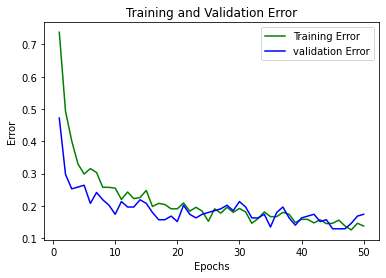

In [23]:
train_error = []
for i in history.history['accuracy']:
  train_error.append(1-i)
val_error = []
for i in history.history['val_accuracy']:
  val_error.append(1-i)
epochs = range(1,51)
plt.plot(epochs, train_error, 'g', label='Training Error')
plt.plot(epochs, val_error, 'b', label='validation Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [24]:
prediction = model.predict(test)

35/35 [==============================] - 1s 37ms/step


In [25]:
predict_classes = np.argmax(prediction,axis=1)

In [26]:
actual_classes = test.classes

In [27]:
accuracy = accuracy_score(actual_classes,predict_classes)
print(accuracy)

0.8362573099415205


In [28]:
print(classification_report(actual_classes, predict_classes, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]))
    

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.80      0.89      0.84         9
           2       0.83      0.62      0.71         8
           3       0.64      0.88      0.74         8
           4       0.80      0.89      0.84         9
           5       0.89      0.89      0.89         9
           6       1.00      1.00      1.00         9
           7       0.82      1.00      0.90         9
           8       0.78      0.78      0.78         9
           9       1.00      0.89      0.94         9
          10       0.90      1.00      0.95         9
          11       1.00      0.78      0.88         9
          12       0.88      0.78      0.82         9
          13       0.64      0.78      0.70         9
          14       0.78      0.78      0.78         9
          15       0.80      0.50      0.62         8
          16       1.00      1.00      1.00         8
          17       1.00    